In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Carga del dataset y variables objetivo a trabajar.
df = pd.read_csv('/content/cardio_train.csv')
target_variables = ["Ejection.Fraction", "Creatinine"]
X = df[target_variables]
y = df['Event']

# Mostrar las primeras filas del dataframe antes de la normalización
print("Dataframe antes de la normalización:")
print(df[target_variables].head())

# Normalización y división del conjunto de datos en entrenamiento y prueba.
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

print("\nDataframe después de la normalización:")
df_normalized = pd.DataFrame(X_normalized, columns=target_variables)
print(df_normalized.head())


Dataframe antes de la normalización:
   Ejection.Fraction  Creatinine
0                 50        1.30
1                 30        1.18
2                 20        1.83
3                 25        1.10
4                 60        1.00

Dataframe después de la normalización:
   Ejection.Fraction  Creatinine
0           0.545455    0.089888
1           0.242424    0.076404
2           0.090909    0.149438
3           0.166667    0.067416
4           0.696970    0.056180


In [19]:
# IMPLEMENTACION RNA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

X = df.drop('Event', axis=1).values
y = df['Event'].values

# Función para construir el modelo
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,),
                           kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preparar la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

# Listas para almacenar métricas
acc_per_fold = []
loss_per_fold = []

for train, test in kf.split(X):
    # Dividir los datos
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    # Construir el modelo
    model = build_model(X_train.shape[1])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1)

    # Entrenar el modelo
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        verbose=0,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluar el modelo en el conjunto de prueba
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Aumentar el número de fold
    fold_no = fold_no + 1

# == Proporcionar estadísticas de validación cruzada ==
print('------------------------------------------------------------------------')
print('Puntuación por fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Promedio de todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# == Métricas Adicionales ==
final_model = build_model(X.shape[1])
final_model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Hacer predicciones con el modelo entrenado en todos los datos
y_pred = (final_model.predict(X) > 0.5).astype(int)
y_prob = final_model.predict(X)  # Métrica ROC AUC

# Calcular métricas adicionales
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)

print(f'ROC AUC: {roc_auc}')


report = classification_report(y, y_pred, digits=2)

# Imprimir las métricas
print(f'Precisión del modelo: {accuracy:.2f}')
print('\nReporte de clasificación:\n', report)


Training for fold 1...

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001.
Restoring model weights from the end of the best epoch: 61.
Epoch 81: early stopping
Score for fold 1: loss of 229.20858764648438; accuracy of 64.99999761581421%
Training for fold 2...

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Restoring model weights from the end of the best epoch: 4.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 24: early stopping
Score for fold 2: loss of 1133.34130859375; accuracy of 69.9999988079071%
Training for fold 3...

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Restoring model weights from the end of the best epoch: 34.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 54: early stopping
Score for fold 3: loss of 1.072883129119873; accuracy of 64.99999761581421%
Training for fold 4...
S

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

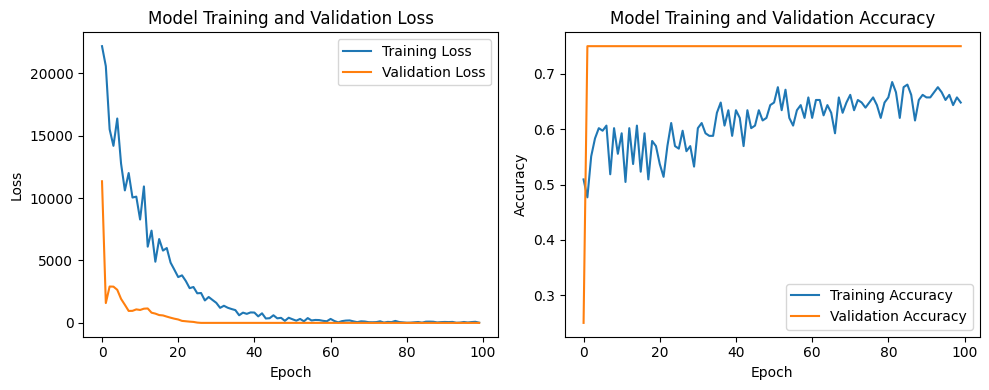

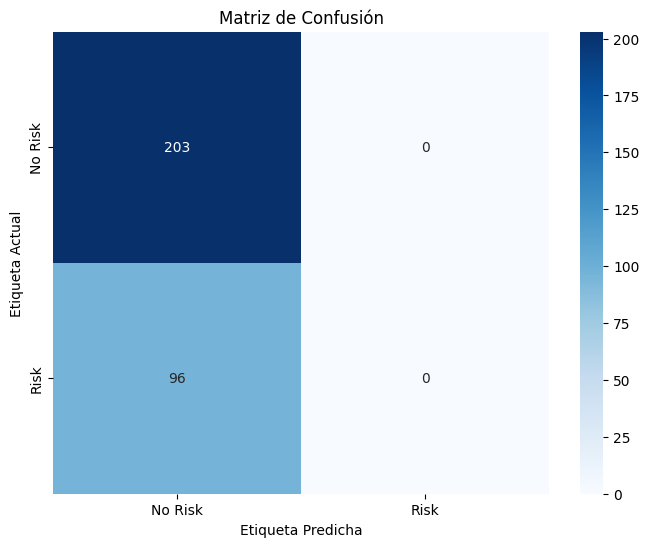

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualizar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(10, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular la matriz de confusión
cm = confusion_matrix(y, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Actual')
plt.xlabel('Etiqueta Predicha')
plt.show()